In [1]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [153]:
path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\cluster_zeta_0.022'
d_cluster = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\cluster_zeta_0.022', \
              suffix = "cluster", priority = -1, LX = 512, Nframes = 1500)
output_path = 'data\\nematic_analysis512_LL0.05\\cluster' 
if not os.path.exists(output_path):
    os.makedirs(output_path)

rm_list = []
for i, file in enumerate(os.listdir(os.path.join(path, os.listdir(path)[0]))):
    if file.startswith('labels'):
        rm_list.append(int(file.split('rm')[-1].split('.')[0]))


In [160]:

rm_list = []

Nclusters = 250
Ncmin = 1
Nframes = 1501
Ndefects = 0
for i, input in enumerate(os.listdir(d_cluster['path'])):
    path = os.path.join(d_cluster['path'], input)
    if i == 0:

        print(f'Analyzing {input}')
        # Load data
        
        for file in os.listdir(path):
            if file.startswith('labels'):
                rm = int(file.split('rm')[-1].split('.')[0])
                if 2 < rm < 150:
                    rm_list.append(int(file.split('rm')[-1].split('.')[0]))

        cluster_arr = np.nan * np.zeros([Nframes, Nclusters - Ncmin, len(rm_list), len(os.listdir(d_cluster['path']))])
        num_clusters = np.zeros([Nframes, len(rm_list), len(os.listdir(d_cluster['path']))])

    with open(os.path.join(path, 'defect_positions.pkl'), 'rb') as f:
        defect_positions = pickle.load(f)

    for k, dist in enumerate(rm_list):
        with open(os.path.join(path, f'labels_rm{dist}.pkl'), 'rb') as f:
            labels = pickle.load(f)
        for j, frame in enumerate(labels):

            if k == 0:
                Ndefects += len(defect_positions[j])

            unique, counts = np.unique(frame, return_counts=True)
            valid_clusters_mask = (counts >= Ncmin)
            num_clusters[j, k, i] = len(unique[valid_clusters_mask])

            # count the number of clusters of each size
            cluster_sizes, cluster_counts = np.unique(counts[valid_clusters_mask], return_counts=True)

            cutoff_mask = (cluster_sizes > Nclusters - 1)
            count_upper  = cutoff_mask.sum()

            cluster_arr[j, cluster_sizes[~cutoff_mask], k, i] = cluster_counts[~cutoff_mask]
            cluster_arr[j, -1, k, i] = count_upper


cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
cluster_arr_std = np.nanstd(cluster_arr, axis = (0,-1)) #/ np.sqrt(cluster_arr.shape[0]*cluster_arr.shape[1])

num_cluster_av = np.mean(num_clusters, axis = (0,-1))
num_cluster_std = np.std(num_clusters, axis = (0,-1))/np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])

Analyzing zeta_0.022_counter_0


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_15136\1887257081.py:48: RuntimeWarning: Mean of empty slice
  cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [218]:
Nupper = 100 - Ncmin
ff = 0

Nmembers_arr = np.nansum(cluster_arr[ff:, :, :, :], axis=(0,-1)) * np.arange(Ncmin, Nclusters)[:, None] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_above = Nmembers_arr[Nupper:,:].sum(axis = 0)
Nmembers_arr = Nmembers_arr[:Nupper,:] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_arr[Nupper - 1,:] += Nmembers_above

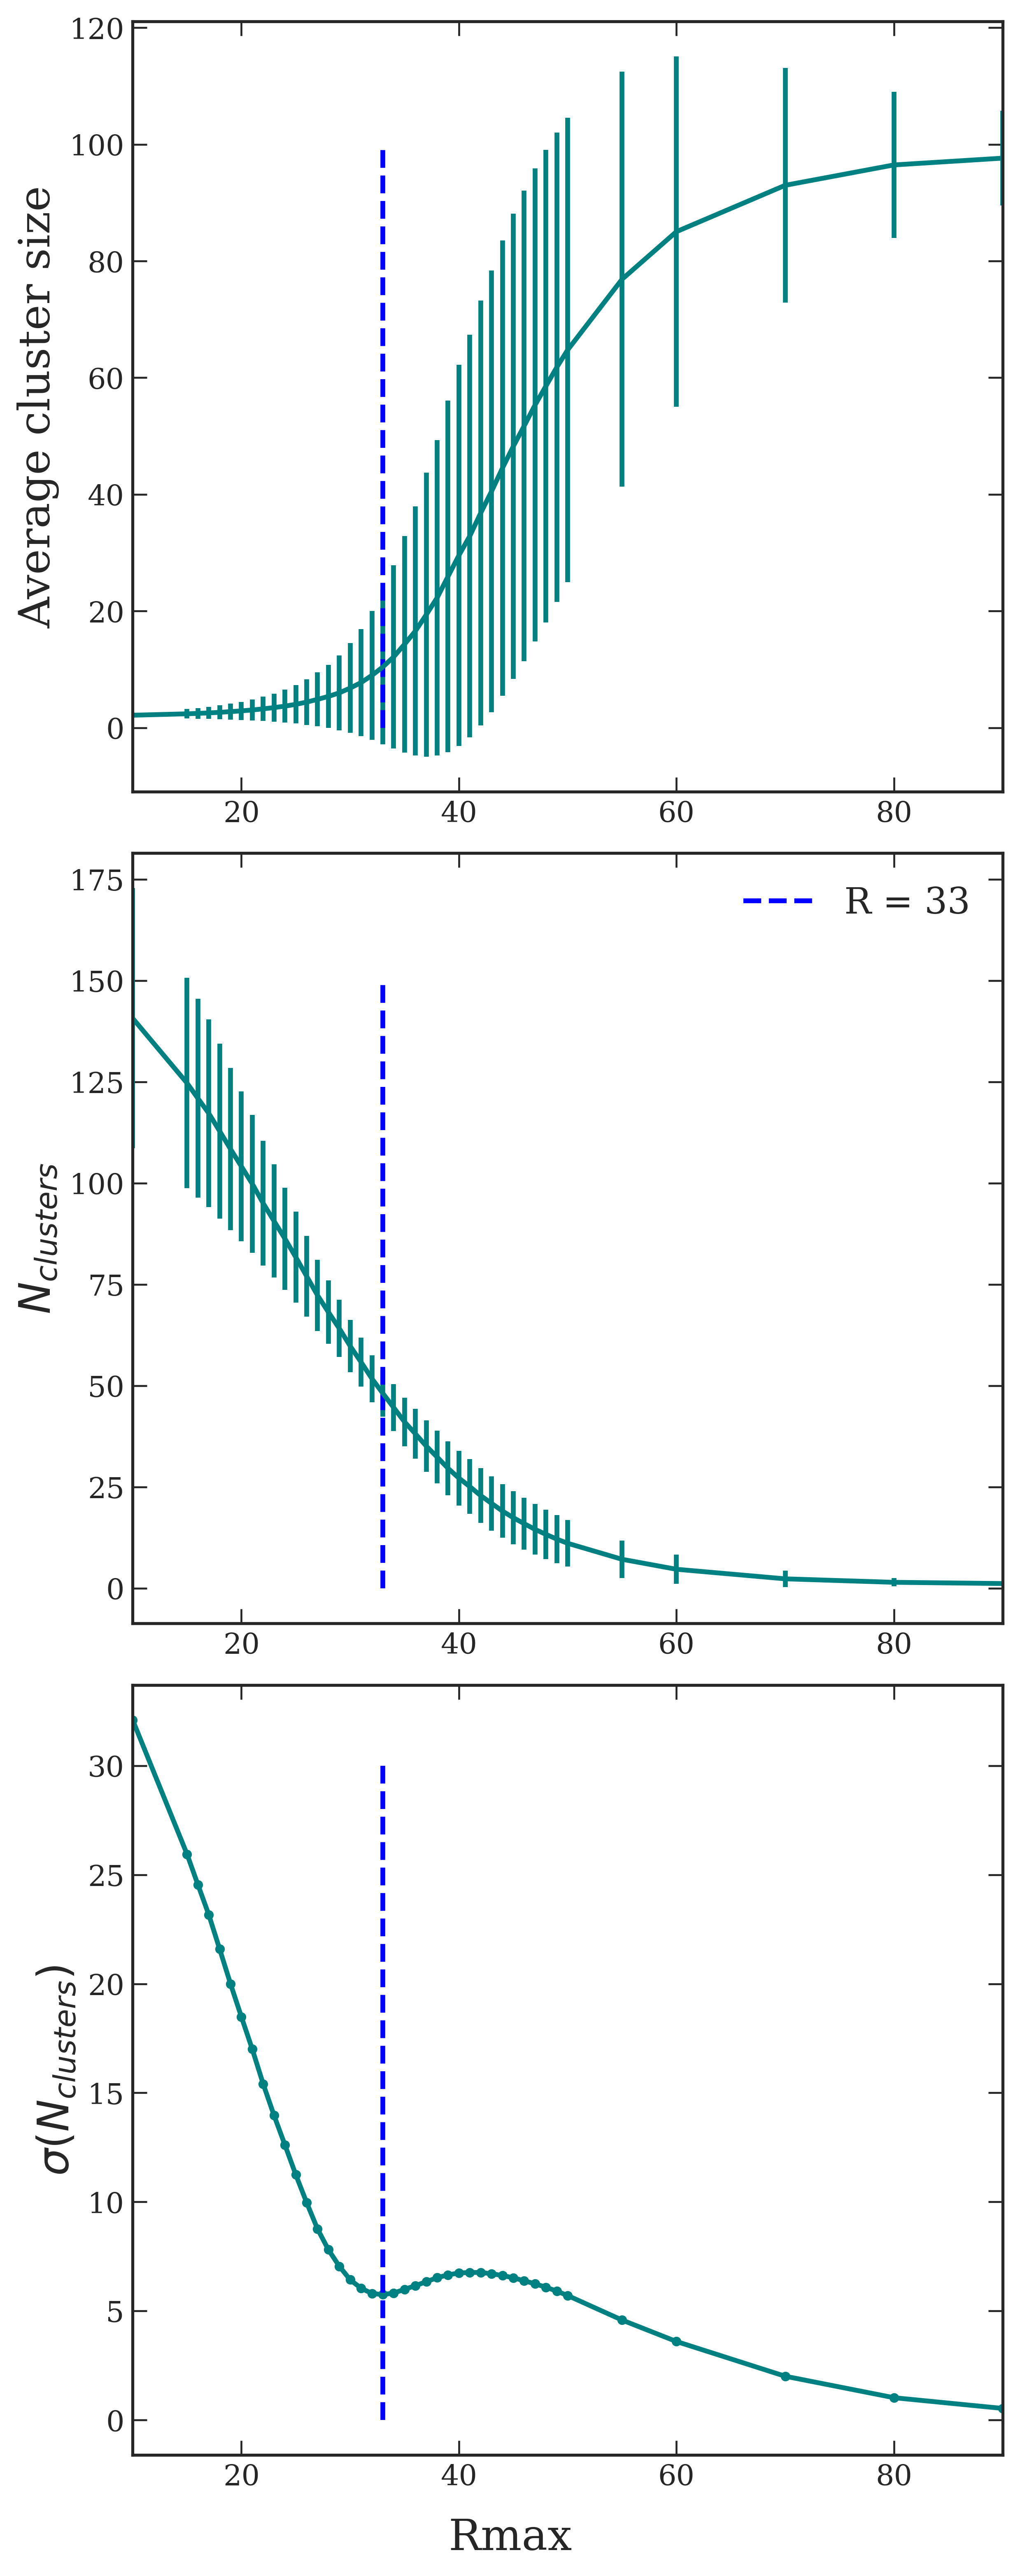

In [228]:
fig, ax = plt.subplots(nrows = 3,ncols=1, figsize=(6,15))
ax = ax.flatten()
Nmembers = Nmembers_arr[:, :] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin) [:, None]
av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)[:,None], axis=0) / Nmembers.sum(axis=0)
std_cluster_size = np.sqrt(np.sum(Nmembers * ((np.arange(Ncmin, Nupper + Ncmin)[:,None] - av_cluster_size[None,:])**2), axis=0)\
                            / Nmembers.sum(axis=0),)


dy = np.diff(av_cluster_size)
dx = np.diff(rm_list)
nc_std = num_cluster_std *np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])
min_idx = np.argwhere(np.diff(nc_std) > 0)[0][0] 


ax[0].errorbar(rm_list, av_cluster_size, std_cluster_size, label = 'Average cluster size')
ax[1].errorbar(rm_list, num_cluster_av, nc_std,)
ax[2].plot(rm_list, nc_std, '.-')

ax[0].set_ylabel('Average cluster size')
ax[1].set_ylabel(r'$N_{clusters}$')
ax[2].set_ylabel(r'$\sigma(N_{clusters})$')
fig.supxlabel('Rmax')
m_list = [100, 150, 30]

for j, axx in enumerate(ax):
    axx.set_xlim([10,90])
    axx.set_xticks(np.arange(20,100,20), np.arange(20,100,20))
    axx.vlines(rm_list[min_idx], 0, m_list[j], label = f'R = {rm_list[min_idx]}', linestyles = 'dashed', color = 'b')
ax[1].legend()
    

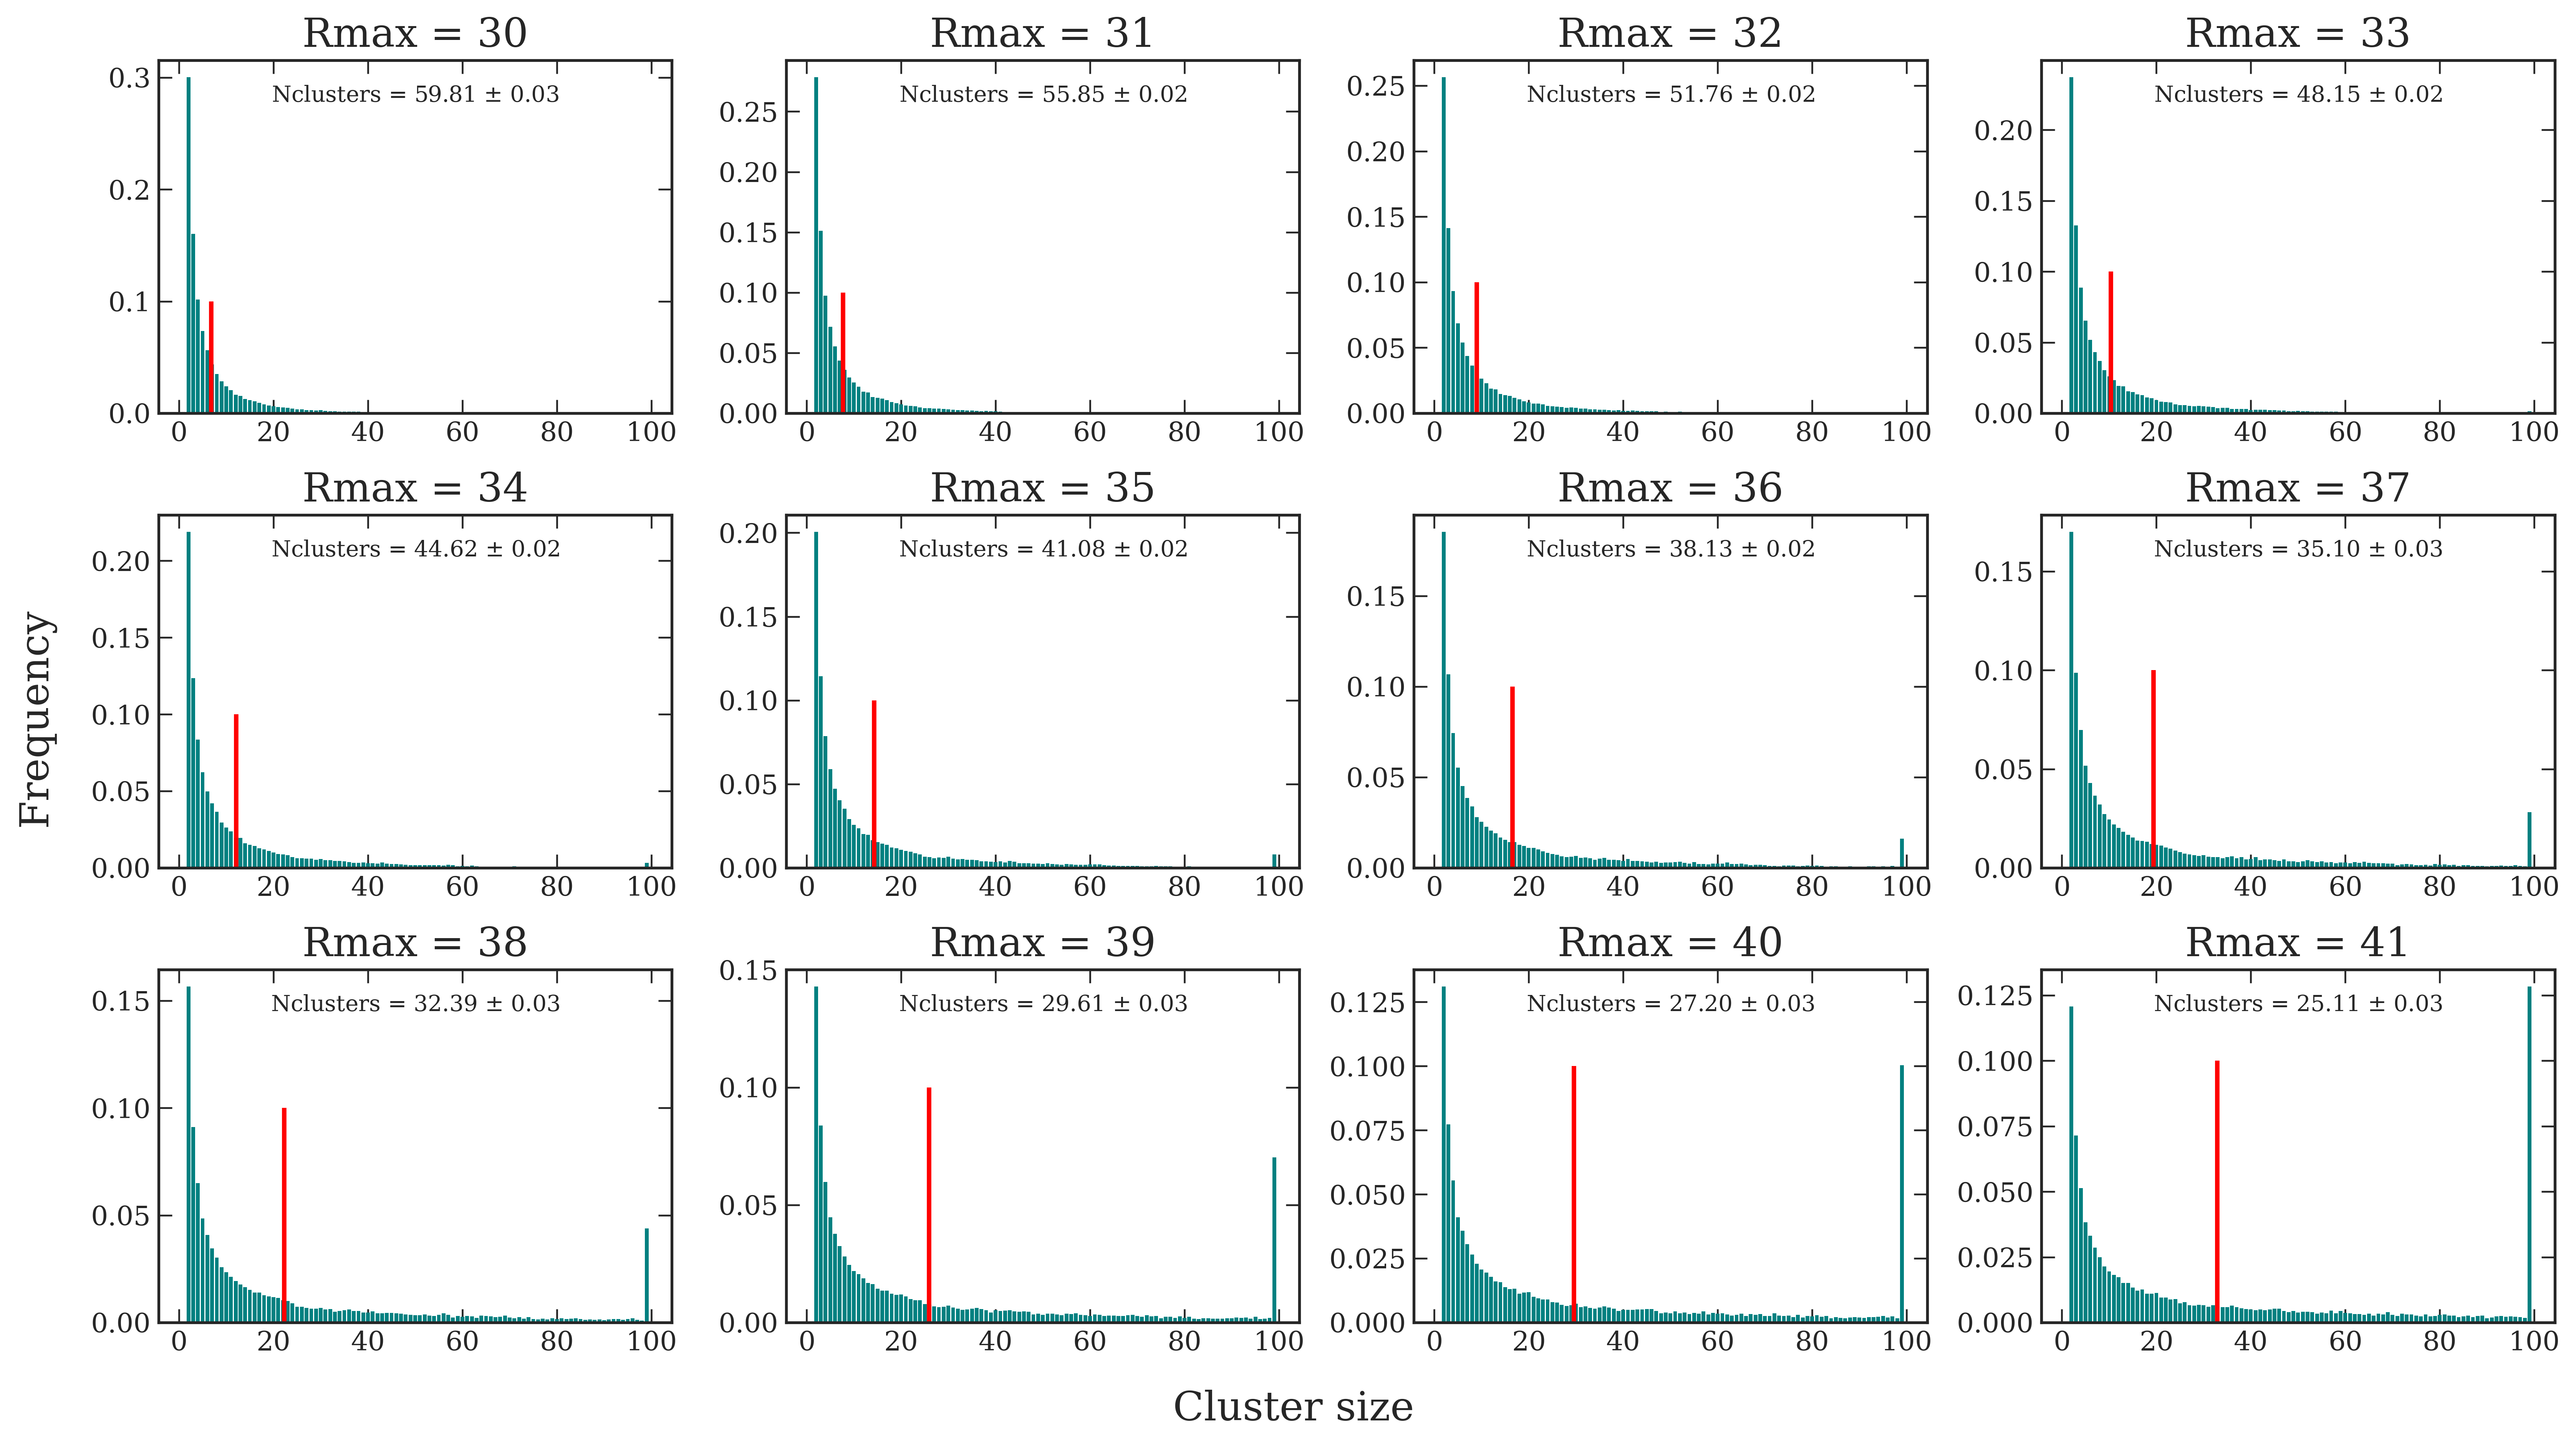

In [237]:
ncols = 4
rm_res = rm_list[16:28]
nrows = int(np.ceil(len(rm_res)/ncols))


fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(16, 3*nrows))
ax = ax.flatten()
for i, dist in enumerate(rm_res):
    idx = rm_list.index(dist)

    Nmembers = Nmembers_arr[:, idx] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

    cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin)
    av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)) / Nmembers.sum()
    std_cluster_size = np.sqrt(np.sum(Nmembers * (np.arange(Ncmin, Nupper + Ncmin) - av_cluster_size)**2) / Nmembers.sum())
    
  
    ax[i].vlines(av_cluster_size, 0, .1, color = 'r')
   # ax[i].vlines(av_cluster_size + std_cluster_size, 0, 2e5, color = 'r', linestyle = '--')
   # ax[i].vlines(av_cluster_size - std_cluster_size, 0, 2e5, color = 'r', linestyle = '--')
    ax[i].bar(np.arange(Ncmin, Nupper + Ncmin), Nmembers / Nmembers.sum()) #, yerr = cluster_arr_std[:,idx],)
    ax[i].set_title(f'Rmax = {dist}')
    #ax[i].hist(cluster_arr[:,:,idx,:].flatten(), bins = 100, range = (1,106));
    
    ax[i].text(0.5, 0.9, f'Nclusters = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
  #  ax[i].set_xticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100+'])
 #   ax[i].set_xlim(1.9,30)
  #  ax[i].set_ylim(0, 12)
fig.supxlabel('Cluster size')
fig.supylabel('Frequency', x = 0.005);

In [78]:
Nclusters_above = np.nansum(cluster_arr[ff:, Nupper:, :, :], axis=(0, 1, -1)) #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)


In [83]:
Nclusters_above / Ndefects

array([0.00000000e+00, 0.00000000e+00, 1.08179273e-06, 2.16358545e-06,
       2.70448181e-06, 1.56859945e-05, 3.78627454e-05, 8.87070035e-05,
       1.72005043e-04, 2.89920450e-04, 4.35421572e-04, 6.70711490e-04,
       9.13033060e-04, 1.13371878e-03, 1.40524875e-03, 1.65838825e-03,
       1.94181794e-03, 2.22146136e-03, 2.49136865e-03, 2.74991711e-03,
       2.96789834e-03, 3.22428322e-03, 3.44659162e-03, 4.35746110e-03,
       4.99680060e-03, 5.57772329e-03, 5.81247231e-03, 5.86385747e-03])

In [86]:
val_mask.sum()

0

In [94]:
vals.shape

(181921200,)

In [92]:
ncols = 4
rm_res = rm_list[:25]
nrows = int(np.ceil(len(rm_res)/ncols))

Nclusters_above = np.nansum(cluster_arr[ff:, Nupper:, :, :], axis=(0, 1, -1))

fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(16, 3*nrows))
ax = ax.flatten()
for i, dist in enumerate(rm_res):
    idx = rm_list.index(dist)

  #  ax[i].bar(np.arange(Nclusters), cluster_arr_av[:,idx]) #, yerr = cluster_arr_std[:,idx],)
    ax[i].set_title(f'Rmax = {dist}')

    #vals_above = cluster_arr[Nupper:, :, idx, :]

    vals = cluster_arr[:,Nupper:,idx,:].flatten()
    vals = np.concatenate([vals, Nupper * np.ones(int(Nclusters_above[idx]))])

   # vals[:, Nupper:, :] = Nupper + Ncmin
   # val_mask = (vals >= Nupper)
    #vals[val_mask] = Nupper

    ax[i].hist(vals, bins = Nupper, range = (Ncmin,Nupper + 2));
 #   ax[i].hist(vals, bins = 20, range = (Ncmin,Nclusters), cumulative=False);
    
    ax[i].text(0.5, 0.9, f'Nclusters = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
  #  ax[i].set_xticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100+'])
 #   ax[i].set_xlim(1.9,30)
  #  ax[i].set_ylim(0, 12)
fig.supxlabel('Cluster size')
fig.supylabel('Av. Count');

In [220]:
df = np.diff(num_cluster_av) / num_cluster_av[1:]
ddf = np.diff(np.diff(num_cluster_av))

In [ ]:
plt.plot(np.array(rm_list)[:-1]+0.5, df)

In [ ]:
plt.plot(np.array(rm_list)[1:-1]+1,ddf)

In [227]:
cluster_arr_av.shape

(101, 28)

In [228]:
Nclusters

101

In [238]:
cluster_arr_av[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [240]:
av_cluster_size.shape

(28,)

In [242]:
len(rm_list)

28

In [260]:
cluster_arr[1000:, 2:, :, :].sum(axis=1).mean(axis=(0,-1))

array([140.72168554, 104.13782478,  59.80696203,  55.84568621,
        51.75932712,  48.14881746,  44.61583944,  41.08361093,
        38.12958028,  35.09785143,  32.38715856,  29.60992672,
        27.1944537 ,  25.10168221,  22.88674217,  20.96127582,
        19.07028648,  17.42105263,  15.95244837,  14.53872418,
        13.30804464,  12.13632578,  11.10468021,   7.15572951,
         4.69487009,   2.33677548,   1.47460027,   1.17430047])

In [264]:
cluster_arr.shape

(1501, 101, 28, 8)

In [270]:
cluster_arr_av.shape

(101, 28)

(10.0, 60.0)

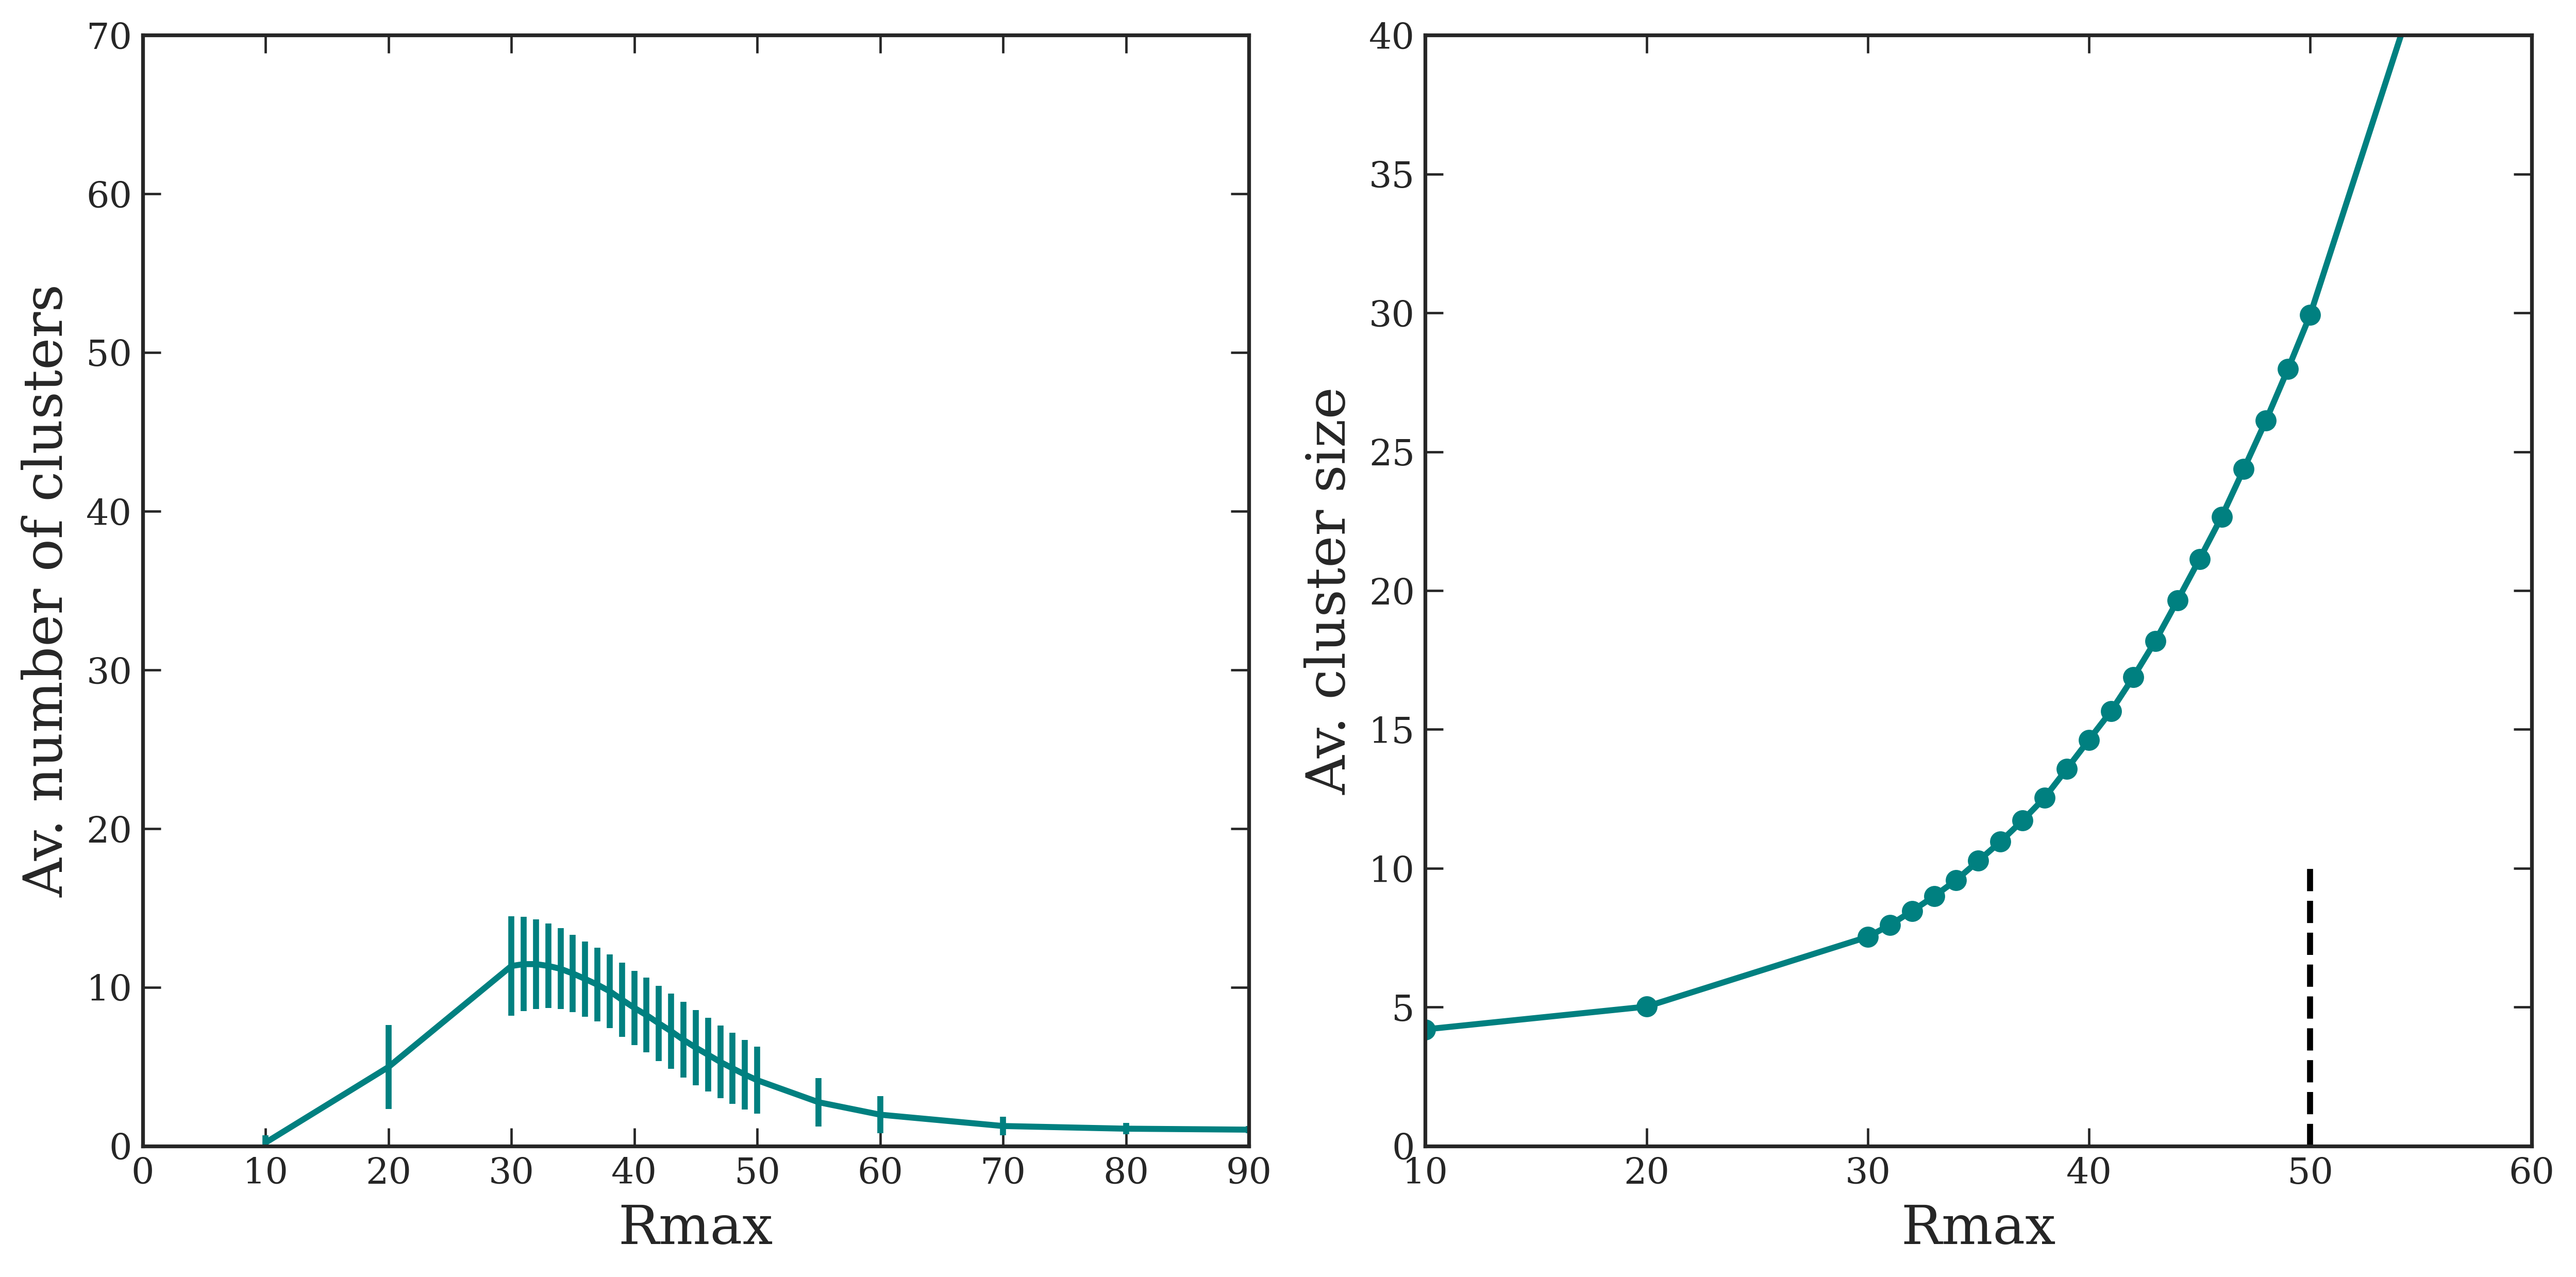

In [274]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ff = 1000
nc_min = 4
num_clusters = cluster_arr[ff:, nc_min:, :, :].sum(axis=1)
num_cluster_avs = np.mean(num_clusters, axis = (0,-1))
num_cluster_stds = np.std(num_clusters, axis = (0,-1))
av_cluster_size = np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)) * np.arange(nc_min,Nclusters)[:, None], axis = 0) / np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)


ax[0].errorbar(rm_list, num_cluster_avs, num_cluster_stds)
ax[0].set_xlabel('Rmax')
ax[0].set_ylabel('Av. number of clusters')
ax[0].set_xlim(0,90)
ax[0].set_ylim(0, 70)

ax[1].plot(rm_list, av_cluster_size, 'o-')#np.diff(av_cluster_size))
ax[1].set_xlabel('Rmax')
ax[1].set_ylabel('Av. cluster size')
ax[1].vlines(50, 0, 10, linestyle='--', color='k')

ax[1].set_ylim(0, 40)
ax[1].set_xlim(10,60)

In [35]:
Nframes

1501

In [ ]:
for i, input in enumerate(d_cluster):
    Nsubdir = 1
    act = []
    act_dir = []
    for j, subdir in enumerate(os.listdir(input)):

        subdir_full = os.path.join(input, subdir)
        act.append(np.round(float(subdir_full.split('_')[-1]),4))
        act_dir.append(subdir_full)
        Nsubdir = max(Nsubdir, len(os.listdir(os.path.join(input, subdir))))

        if not os.path.isdir(self.output_paths[i]):
            os.makedirs(self.output_paths[i])

        if not os.path.isfile(os.path.join(self.output_paths[i], 'window_sizes.txt')):
            subsubdir = os.path.join(subdir_full, os.listdir(subdir_full)[0])
            dir_windows = os.path.join(subsubdir, 'window_sizes.txt')
            windows = np.loadtxt(dir_windows)   
            np.savetxt(os.path.join(self.output_paths[i], 'window_sizes.txt'), windows)
        else:
            windows = np.loadtxt(os.path.join(self.output_paths[i], 'window_sizes.txt'))
        self.window_sizes.append(windows)
            
        if not os.path.isfile(os.path.join(self.output_paths[i], 'kbins.txt')) or not os.path.isfile(os.path.join(self.output_paths[i], 'rad.txt')):
            subsubdir = os.path.join(subdir_full, os.listdir(subdir_full)[0])
            dir_kbins = os.path.join(subsubdir, 'kbins.txt')
            dir_rad = os.path.join(subsubdir, 'rad.txt')

            # save the kbins and rad if they exist
            if os.path.isfile(dir_kbins):
                kbins = np.loadtxt(dir_kbins)
                np.savetxt(os.path.join(self.output_paths[i], 'kbins.txt'), kbins)
            if os.path.isfile(dir_rad):
                rad = np.loadtxt(dir_rad)
                np.savetxt(os.path.join(self.output_paths[i], 'rad.txt'), rad)

    act, act_dir = zip(*sorted(zip(act, act_dir)))

    # save the activity list
    np.savetxt(os.path.join(self.output_paths[i], 'activity_list.txt'), act)

    self.act_list.append(act)
    self.act_dir_list.append(act_dir)
    self.Nexp.append(Nsubdir)

for i, output in enumerate(self.output_paths):
    if not os.path.exists(output):
        os.makedirs(output)
    if not os.path.exists(os.path.join(output, 'figs')):
        os.makedirs(os.path.join(output, 'figs'))   

    # load the convergence list if it exists
    try:
        self.conv_list.append(np.loadtxt(os.path.join(output, 'conv_list.txt')).astype(int))
    except:
        self.conv_list.append([0] * self.Nactivity[i])